<img src="spam.jpg" />

# Spam Classifier

### Objectif : Concevoir un classifieur de détection automatique de SPAM.

La collection SMS Spam est un ensemble de messages SMS marqués qui ont été collectés pour la recherche sur les SMS Spam. Elle contient un ensemble de messages SMS en anglais de 5 574 messages, étiquetés selon qu'ils sont ham (légitimes) ou spam.

## Sommaire

### [EDA](#chapter1)
* [Valeurs en double](#duplicate)
* [Nettoyage de l'encoding](#cleaning_encoding)

### [Features extraction](#features_extraction)
* [Longueur du texte](#length)
* [Nombre de mots](#words_count)
* [Nombre de majuscules](#uppercases_count)
* [Nombre de minuscules](#lowercases_count)
* [Présence d'un numéro de téléphone](#phone_number)
* [Présence d'une url ou d'un mail](#url_or_mail)
* [Nombre de caractères spéciaux](#special_char_count)
* [Wordcloud](#wordcloud)

### [Preprocessing](#preprocessing)
### [Normalise](#normalise)
### [Pipeline ML](#pipeline_ml)
### [Prédiction](#prediction)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import string

In [2]:
df = pd.read_csv('spam.csv',encoding = "latin-1")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
df.drop(['Unnamed: 2', 'Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
df.rename(columns={"v1": "target", "v2": "text"},inplace=True)

In [5]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.describe()

,target,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


# EDA <a class="anchor" id="chapter1"></a>

In [7]:
df['target'].value_counts()

ham     4825
spam     747
Name: target, dtype: int64

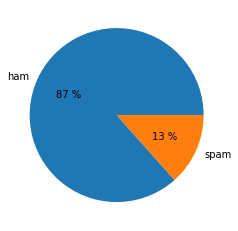

In [8]:
plt.pie(df["target"].value_counts(),labels=["ham","spam"],autopct="%.0f %%")
plt.show()

### Valeurs en double <a class="anchor" id="duplicate"></a>

In [9]:
df.duplicated().value_counts()

False    5169
True      403
dtype: int64

In [10]:
df.drop_duplicates(inplace=True) # (pour Noli,inplace supprimer directement sur la df)

In [11]:
df.duplicated().value_counts() # Verification apres suppression

False    5169
dtype: int64

### Nettoyage de l'encoding <a class="anchor" id="cleaning_encoding"></a>

In [12]:
def text_cleaning_encoding(text):
    text = re.sub('&lt;#&gt;',"",text) #Removing square brackets from the text
    return(text) 

In [13]:
df['text'] = df['text'].apply(text_cleaning_encoding)

# Features extraction <a class="anchor" id="features_extraction"></a>

#### Longueur du texte <a class="anchor" id="length"></a>

In [14]:
df['length'] = df['text'].str.len()

In [15]:
df.head() # Verification

,target,text,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


#### Nombre de mots <a class="anchor" id="words_count"></a>

In [16]:
df['words_count'] = df['text'].apply(lambda x: len(x.split(" ")))

In [17]:
df.head() # Verification

,target,text,length,words_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28
3,ham,U dun say so early hor... U c already then say...,49,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13


#### Nombre de majuscules <a class="anchor" id="uppercases_count"></a>

In [18]:
df['uppercases_count'] = df['text'].str.findall(r'[A-Z]').str.len()

In [19]:
df.head() # Verification

,target,text,length,words_count,uppercases_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3
1,ham,Ok lar... Joking wif u oni...,29,6,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,10
3,ham,U dun say so early hor... U c already then say...,49,11,2
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,2


#### Nombre de minuscules <a class="anchor" id="lowercases_count"></a>

In [20]:
df['lowercases_count'] = df['text'].str.findall(r'[a-z]').str.len()

In [21]:
df.head()

,target,text,length,words_count,uppercases_count,lowercases_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,80
1,ham,Ok lar... Joking wif u oni...,29,6,2,16
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,10,87
3,ham,U dun say so early hor... U c already then say...,49,11,2,31
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,2,45


#### Presence d'un numéro de téléphone <a class="anchor" id="phone_number"></a>

In [22]:
def isNumberSequenceInText(txt):
    if bool(re.search("(\d{2})", txt)):
        return 1
    else:
        return 0

In [23]:
df['number_sequence'] = df['text'].map(isNumberSequenceInText)

In [24]:
df.head() # Verification

,target,text,length,words_count,uppercases_count,lowercases_count,number_sequence
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,80,0
1,ham,Ok lar... Joking wif u oni...,29,6,2,16,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,10,87,1
3,ham,U dun say so early hor... U c already then say...,49,11,2,31,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,2,45,0


In [25]:
df.groupby(['target'])['number_sequence'].sum()

target
ham      97
spam    580
Name: number_sequence, dtype: int64

Text(0.5, 1.0, 'le rapport ham/spam quand il y a au mois 2 chiffres de suites')

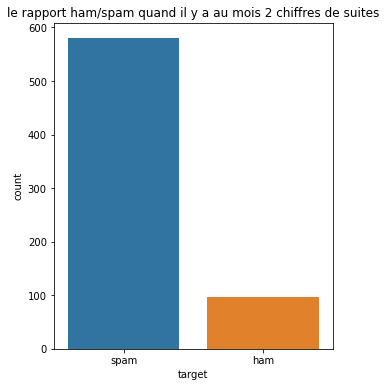

In [26]:
df1 = df[df['number_sequence'] == 1]
plt.figure(figsize=(5,6),)
sns.countplot(x=df1['target']).set_title('le rapport ham/spam quand il y a au mois 2 chiffres de suites')

#### Présence d'une url ou d'un mail <a class="anchor" id="url_or_mail"></a>

In [27]:
# Ancien ReGex -> \.[a-z]{2,3}(\.|\s|$)|(https?:\/\/|www\.)[a-zA-Z0-9-_\.]+

def isUrlMailInText(txt):
    if bool(re.search("((https?:\/\/|www\.)[a-zA-Z0-9-_\.]+)|(\w+@\w+)", txt)):
        return 1
    else:
        return 0

In [28]:
df['url_or_mail'] = df['text'].map(isUrlMailInText)

In [29]:
df.head() # Verification

,target,text,length,words_count,uppercases_count,lowercases_count,number_sequence,url_or_mail
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,80,0,0
1,ham,Ok lar... Joking wif u oni...,29,6,2,16,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,10,87,1,0
3,ham,U dun say so early hor... U c already then say...,49,11,2,31,0,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,2,45,0,0


In [30]:
df.groupby(['target'])['url_or_mail'].sum()

target
ham       2
spam    103
Name: url_or_mail, dtype: int64

Text(0.5, 1.0, "Rapport ham/spam si présence d'une url ou d'un mail")

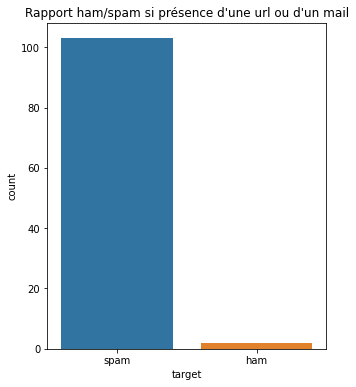

In [31]:
df1 = df[df['url_or_mail'] == 1]
plt.figure(figsize=(5,6),)
sns.countplot(x=df1['target']).set_title('Rapport ham/spam si présence d\'une url ou d\'un mail')

#### Nombre de caractères spéciaux <a class="anchor" id="special_char_count"></a>

In [32]:
# Modification de la fonction pour sortir des catégories
# categorie : nb de caracteres speciaux
# cat 1 : [1]
# cat 2 : [2-6]
# cat 3 : [7-12]
# cat 4 : [13+]

def countSpecialCharInText(txt):
    category = 0
    nbSpecialChar = len(re.findall("[$&+:;=?@#|'<>^*()%!-]", txt))
    if nbSpecialChar == 1:
        category = 1
    elif nbSpecialChar > 1 and nbSpecialChar < 7:
        category = 2
    elif nbSpecialChar > 6 and nbSpecialChar < 13:
        category = 3
    elif nbSpecialChar > 12:
        category = 4
        
    return category

In [33]:
df['special_char_count'] = df['text'].map(countSpecialCharInText)

In [34]:
df.head() # Verification

,target,text,length,words_count,uppercases_count,lowercases_count,number_sequence,url_or_mail,special_char_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,80,0,0,0
1,ham,Ok lar... Joking wif u oni...,29,6,2,16,0,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,10,87,1,0,2
3,ham,U dun say so early hor... U c already then say...,49,11,2,31,0,0,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,2,45,0,0,1


In [35]:
df[df['special_char_count'] == 0]

,target,text,length,words_count,uppercases_count,lowercases_count,number_sequence,url_or_mail,special_char_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,80,0,0,0
1,ham,Ok lar... Joking wif u oni...,29,6,2,16,0,0,0
3,ham,U dun say so early hor... U c already then say...,49,11,2,31,0,0,0
6,ham,Even my brother is not like to speak with me. ...,77,16,2,58,0,0,0
17,ham,Eh u remember how 2 spell his name... Yes i di...,81,19,3,54,0,0,0
...,...,...,...,...,...,...,...,...,...
5561,ham,Get me out of this dump heap. My mom decided t...,70,15,8,45,0,0,0
5562,ham,Ok lor... Sony ericsson salesman... I ask shuh...,96,18,3,66,0,0,0
5563,ham,Ard 6 like dat lor.,19,5,1,12,0,0,0
5565,ham,Huh y lei...,12,3,1,6,0,0,0


In [36]:
cTabSpecialChar = pd.crosstab(df['target'], df['special_char_count'])

In [37]:
cTabSpecialChar

special_char_count,0,1,2,3,4
target,,,,,
ham,1933,1280,1219,74,10
spam,110,134,386,18,5


<AxesSubplot:xlabel='special_char_count', ylabel='Count'>

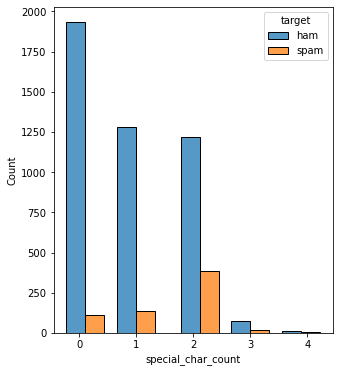

In [38]:
plt.figure(figsize=(5,6),)
sns.histplot(data=df, x="special_char_count", hue="target", multiple="dodge", shrink=3)

# Wordcloud <a class="anchor" id="wordcloud"></a>

#### Préparation

In [39]:
def text_cleaning(text):
    text = str(text).lower() #Converting text into lowercase
    text = re.sub('\[.*?\]','',text) #Removing square brackets from the text
    text = re.sub('https?://\S+|www\.\S+', '', text) #Removing links starting with (https or www)
    text = re.sub('<.*?>+','',text) #Removing <"text"> type of text
    text = re.sub("[%s]" % re.escape(string.punctuation),'',text) #Removing punctuations
    text = re.sub("\n",'',text) #Removing new lines
    text = re.sub('\w*\d\w*','',text) #Removing alphanumeric numbers
    text = re.sub('û÷',"'",text) # Remplacement caractères non encodés
    text = re.sub('åõ',"'",text) # Remplacement caractères non encodés
    return(text)

In [40]:
df['text'] = df['text'].apply(text_cleaning)

In [41]:
strHam = ""
strSpam = ""

for idx, series in df.iterrows():
    if series['target'] == 'ham': 
        strHam += series['text']
        strHam += " "
    else:
        strSpam += series['text']
        strSpam += " "

In [42]:
df['text'].head(25)

0     go until jurong point crazy available only in ...
1                               ok lar joking wif u oni
2     free entry in  a wkly comp to win fa cup final...
3           u dun say so early hor u c already then say
4     nah i dont think he goes to usf he lives aroun...
5     freemsg hey there darling its been  weeks now ...
6     even my brother is not like to speak with me t...
7     as per your request melle melle oru minnaminun...
8     winner as a valued network customer you have b...
9     had your mobile  months or more u r entitled t...
10    im gonna be home soon and i dont want to talk ...
11    six chances to win cash from  to  pounds txt  ...
12    urgent you have won a  week free membership in...
13    ive been searching for the right words to than...
14                    i have a date on sunday with will
15    xxxmobilemovieclub to use your credit click th...
16                                 oh kim watching here
17    eh u remember how  spell his name yes i di

In [43]:
strHam

"go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat ok lar joking wif u oni u dun say so early hor u c already then say nah i dont think he goes to usf he lives around here though even my brother is not like to speak with me they treat me like aids patent as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertune for all callers press  to copy your friends callertune im gonna be home soon and i dont want to talk about this stuff anymore tonight k ive cried enough today ive been searching for the right words to thank you for this breather i promise i wont take your help for granted and will fulfil my promise you have been wonderful and a blessing at all times i have a date on sunday with will oh kim watching here eh u remember how  spell his name yes i did he v naughty make until i v wet fine if that's the way u feel that's the way its gota b is that seriously how you spell his name i\x89'm going

<Figure size 432x288 with 0 Axes>

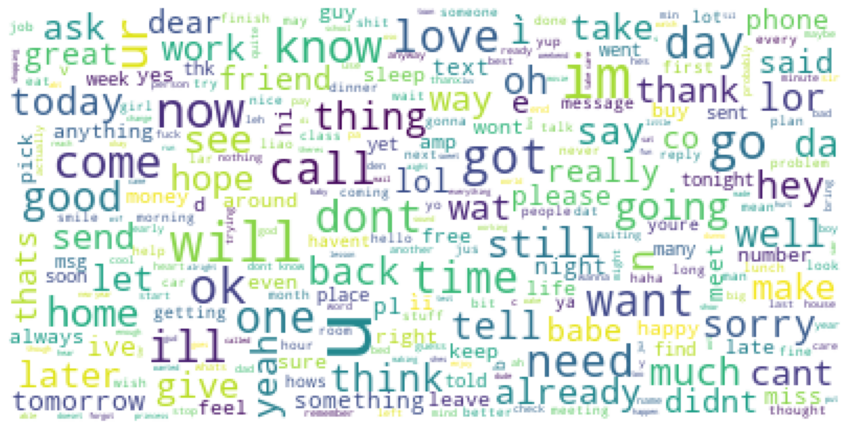

In [44]:
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud().generate(strHam)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=len(strHam),max_font_size=40, relative_scaling=.5).generate(strHam)
plt.figure()
plt.figure( figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Wordcloud des Spam

<Figure size 432x288 with 0 Axes>

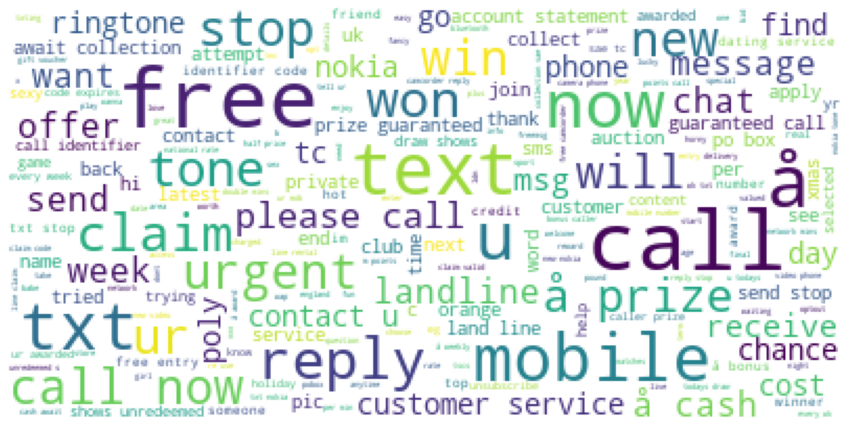

In [45]:
# Generate a word cloud image
wordcloud = WordCloud().generate(strSpam)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=len(strSpam),max_font_size=40, relative_scaling=.5).generate(strSpam)
plt.figure()
plt.figure( figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

prize, urgent, free, mobile, please call, call now, cash, chat, win, txt, now, reply, phone, new, now, call, tone, claim, won, chance 

In [46]:
wordsList = ['prize','urgent','free','mobile','please','cash','chat','win','txt','reply','phone','new','now','call','tone','claim','won','chance']

In [47]:
def countWordsInText(txt):
    res = 0
    nb = 0
    for i in wordsList:
        nb += len(re.findall(r"\b" + i + r"\b", txt))
            
    if nb > 3:
        res = 1
    else:
        res = 0

    return res

In [48]:
for r in df['text']:
    print("-- ",r,countWordsInText(r))

--  go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat 0
--  ok lar joking wif u oni 0
--  free entry in  a wkly comp to win fa cup final tkts  may  text fa to  to receive entry questionstd txt ratetcs apply  0
--  u dun say so early hor u c already then say 0
--  nah i dont think he goes to usf he lives around here though 0
--  freemsg hey there darling its been  weeks now and no word back id like some fun you up for it still tb ok xxx std chgs to send å£ to rcv 0
--  even my brother is not like to speak with me they treat me like aids patent 0
--  as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertune for all callers press  to copy your friends callertune 0
--  winner as a valued network customer you have been selected to receivea å£ prize reward to claim call  claim code  valid  hours only 1
--  had your mobile  months or more u r entitled to update to the latest colour mobiles with camer

--  yes i will be there glad you made it 0
--  do well all will for little time thing of good times ahead 0
--  just got up have to be out of the room very soon û i hadnt put the clocks back til at  i shouted at everyone to get up and then realised it was  wahay another hour in bed 0
--  ok there may be a free gym about 0
--  men like shorter ladies gaze up into his eyes 0
--  dunno he jus say go lido same time  0
--  i promise to take good care of you princess i have to run now please send pics when you get a chance ttyl 0
--  u are subscribed to the best mobile content service in the uk for å£ per  days until you send stop to  helpline  0
--  is there a reason weve not spoken this year anyways have a great week and all the best in your exam 0
--  by monday next week give me the full gist 0
--  do you realize that in about  years well have thousands of old ladies running around with tattoos 0
--  you have an important customer service announcement from premier 0
--  dont gimme that l

--  god picked up a flower and dippeditinadew lovingly touched itwhichturnedinto u and the he gifted tomeandsaidthis friend is  0
--  when you came to hostel 0
--  ok no prob ill come after lunch then 0
--  jus telling u dat ill b leaving  shanghai on  instead so well haf more time  meet up cya 0
--  are your freezing  are you home yet  will you remember to kiss your mom in the morning do you love me  do you think of me  are you missing me yet  0
--  you all ready for  big day tomorrow 0
--  ill probably be around mu a lot 0
--   0
--  rtking pro video club need help inforingtonekingcouk or call  you must be  club credits redeemable at  enjoy 0
--  thnx dude u guys out  0
--  me sef dey laugh you meanwhile hows my darling anjie 0
--  mm i had my food da from out 0
--  k makes sense btw carlos is being difficult so you guys are gonna smoke while i go pick up the second batch and get gas 0
--  did u download the fring app 0
--  the  oz guy is being kinda flaky but one friend is intereste

--  oh ya ya i remember da  0
--  btw regarding that we should really try to see if anyone else can be our  guy before we commit to a random dude 0
--  for ur chance to win å£ cash every wk txt play to  tscs  custcare   1
--  i not busy juz dun wan  go so early hee  0
--  rightio  it is then well arent we all up bright and early this morning 0
--  great im in church now will holla when i get out 0
--  back in brum thanks for putting us up and keeping us all and happy see you soon  0
--  i donno if they are scorable 0
--    great loxahatchee xmas tree burning update you can totally see stars here 0
--  yes but i dont care i need you bad princess 0
--  the guy kadeem hasnt been selling since the break i know one other guy but hes paranoid as fuck and doesnt like selling without me there and i cant be up there til late tonight 0
--  tmr then ì brin lar aiya later i come n c lar mayb ì neva set properly ì got da help sheet wif ì 0
--  do u knw dis no   0
--  then she dun believe wat 0
--  

--  ur awarded a city break and could win a å£ summer shopping spree every wk txt store to £ 0
--  is ur paper today in e morn or aft 0
--  i will lick up every drop  are you ready to use your mouth as well 0
--  and you will expect you whenever you text hope all goes well tomo  0
--  great p diddy is my neighbor and comes for toothpaste every morning 0
--  i av a new number   wil u only use this oneta 0
--  so its to be poking man everyday that they teach you in canada abi how are you just saying hi 0
--   lor change  suntec wat time u coming 0
--  no deam seeing in online shop so that i asked 0
--  just curious because my cuz asked what i was up to 0
--  okay lor wah like that def they wont let us go haha what did they say in the terms and conditions 0
--  haha yup hopefully  we will lose a few kg by mon after hip hop can go orchard and weigh again 0
--  shes good how are you where r u working now 0
--  oh yes ive just been a little under the weather so ive kind of been coccooning at

--  prof you have passed in all the papers in this sem congrats     student enna kalaachutaarama prof gud mrng 0
--  dont kick coco when hes down 0
--  fyi im gonna call you sporadically starting at like    bc we are not not doin this shit 0
--  you are being contacted by our dating service by someone you know to find out who it is call from your mobile or landline    0
--  tbspersolvo been chasing us since sept forå£ definitely not paying now thanks to your information we will ignore them kath manchester 0
--  hope you're not having too much fun without me see u tomorrow love jess x 0
--  ok i wont call or disturb any one i know all are avoiding me i am a burden for all 0
--  ive reached home n i bathe liao u can call me now 0
--  loans for any purpose even if you have bad credit tenants welcome call noworriesloanscom on  0
--  was the actual exam harder than nbme 0
--  a lot of this sickness thing going round take it easy hope u feel better soon lol 0
--   kick off a new season with 

--  indeed and by the way it was either or  not both  0
--  urgent call  landline your complimentary  ibiza holiday or å£ cash await collection sae tcs po box      0
--  holy living christ what is taking you so long 0
--  ìï thk of wat to eat tonight 0
--  thanx yup we coming back on sun finish dinner going back  hotel now time flies were tog  exactly a mth today hope well haf many more mths to come 0
--  were on the opposite side from where we dropped you off 0
--  yup izzit still raining heavily cos im in e mrt i cant c outside 0
--  send me your resume 0
--  gd luck  ur exams  0
--  or u ask they all if next sat can a not if all of them can make it then im ok lor 0
--  sorry that was my uncle ill keep in touch 0
--  saw guys and dolls last night with patrick swayze it was great 0
--  urgent this is our  attempt to contact u your å£ prize from yesterday is still awaiting collection to claim call now  1
--  santa calling would your little ones like a call from santa xmas eve call  to 

In [49]:
df['words_fateful_count'] = df['text'].map(countWordsInText)

In [50]:
df.groupby(['target'])['words_fateful_count'].sum()

target
ham       5
spam    176
Name: words_fateful_count, dtype: int64

# Preprocessing <a class="anchor" id="preprocessing"></a>

In [51]:
df.head()

,target,text,length,words_count,uppercases_count,lowercases_count,number_sequence,url_or_mail,special_char_count,words_fateful_count
0,ham,go until jurong point crazy available only in ...,111,20,3,80,0,0,0,0
1,ham,ok lar joking wif u oni,29,6,2,16,0,0,0,0
2,spam,free entry in a wkly comp to win fa cup final...,155,28,10,87,1,0,2,0
3,ham,u dun say so early hor u c already then say,49,11,2,31,0,0,0,0
4,ham,nah i dont think he goes to usf he lives aroun...,61,13,2,45,0,0,1,0


In [52]:
df.drop('text',axis=1,inplace=True)

In [53]:
from sklearn.preprocessing import LabelEncoder

# target preprocessing
lb_encod = LabelEncoder()
y = lb_encod.fit_transform(df['target'])

In [54]:
# features preprocessing
#X = df.drop(columns='target')
X = df.drop(columns=['target','special_char_count','words_fateful_count'])
X.head()

,length,words_count,uppercases_count,lowercases_count,number_sequence,url_or_mail
0,111,20,3,80,0,0
1,29,6,2,16,0,0
2,155,28,10,87,1,0
3,49,11,2,31,0,0
4,61,13,2,45,0,0


# Normalise <a class="anchor" id="normalise"></a>

In [55]:
# Selection des colonnes a normaliser
#column_num = ['length','words_count','uppercases_count','lowercases_count','special_char_count','words_fateful_count']
column_num = ['length','words_count','uppercases_count','lowercases_count']

Recherche d'un scaler

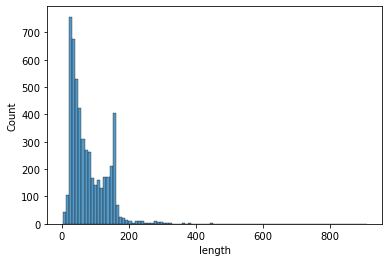

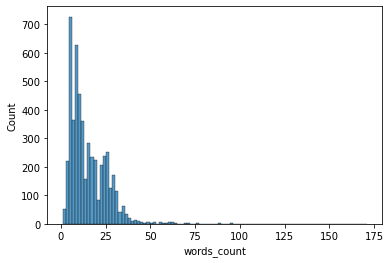

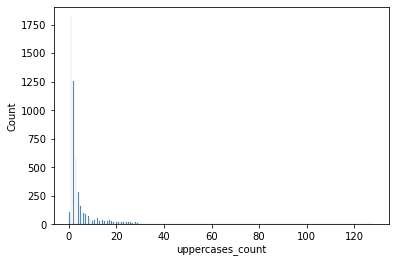

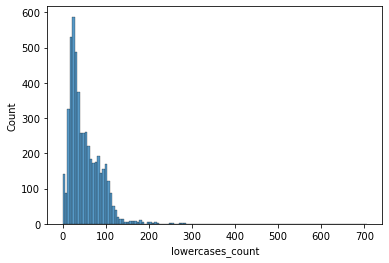

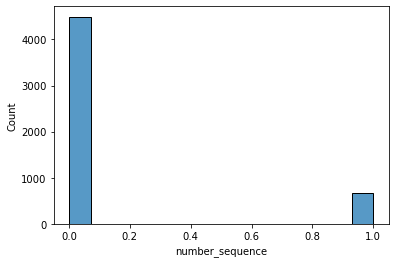

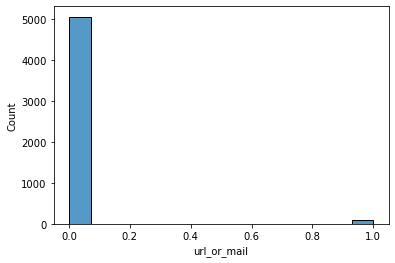

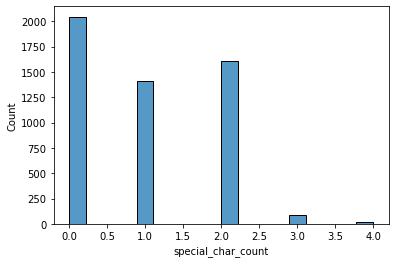

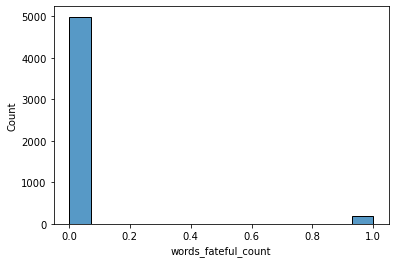

In [56]:
# Distribution
for col in df[df.columns.drop('target')]:
    plt.figure()
    sns.histplot(df[col])

In [57]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

transfo_num = Pipeline(steps=[('scaling', MinMaxScaler())])

# Pipeline ML <a class="anchor" id="pipeline_ml"></a>

In [58]:
from sklearn.compose import ColumnTransformer

# Class ColumnTransformer : apply alls steps on the whole dataset
preparation = ColumnTransformer(transformers=[('data_num', transfo_num , column_num)])

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Creation of model : a ready to use pipeline for ML process
model = DecisionTreeClassifier(max_depth=5)
model1 = RandomForestClassifier(max_depth=5, random_state=0)
pipe_model = Pipeline(steps=[
    ('preparation', preparation),
    ('DecisionTreeClassifier',model)
])
pipe_model

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('data_num',
                                                  Pipeline(steps=[('scaling',
                                                                   MinMaxScaler())]),
                                                  ['length', 'words_count',
                                                   'uppercases_count',
                                                   'lowercases_count'])])),
                ('model', DecisionTreeClassifier(max_depth=5))])

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [61]:
pipe_model.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('data_num',
                                                  Pipeline(steps=[('scaling',
                                                                   MinMaxScaler())]),
                                                  ['length', 'words_count',
                                                   'uppercases_count',
                                                   'lowercases_count'])])),
                ('model', DecisionTreeClassifier(max_depth=5))])

### Prédiction <a class="anchor" id="prediction"></a>

In [62]:
y_pred = pipe_model.predict(X_test)

In [63]:
from sklearn.metrics import accuracy_score
# Score of models
score = accuracy_score(y_test, y_pred)
print("score :", round(score, 5))

score : 0.94681


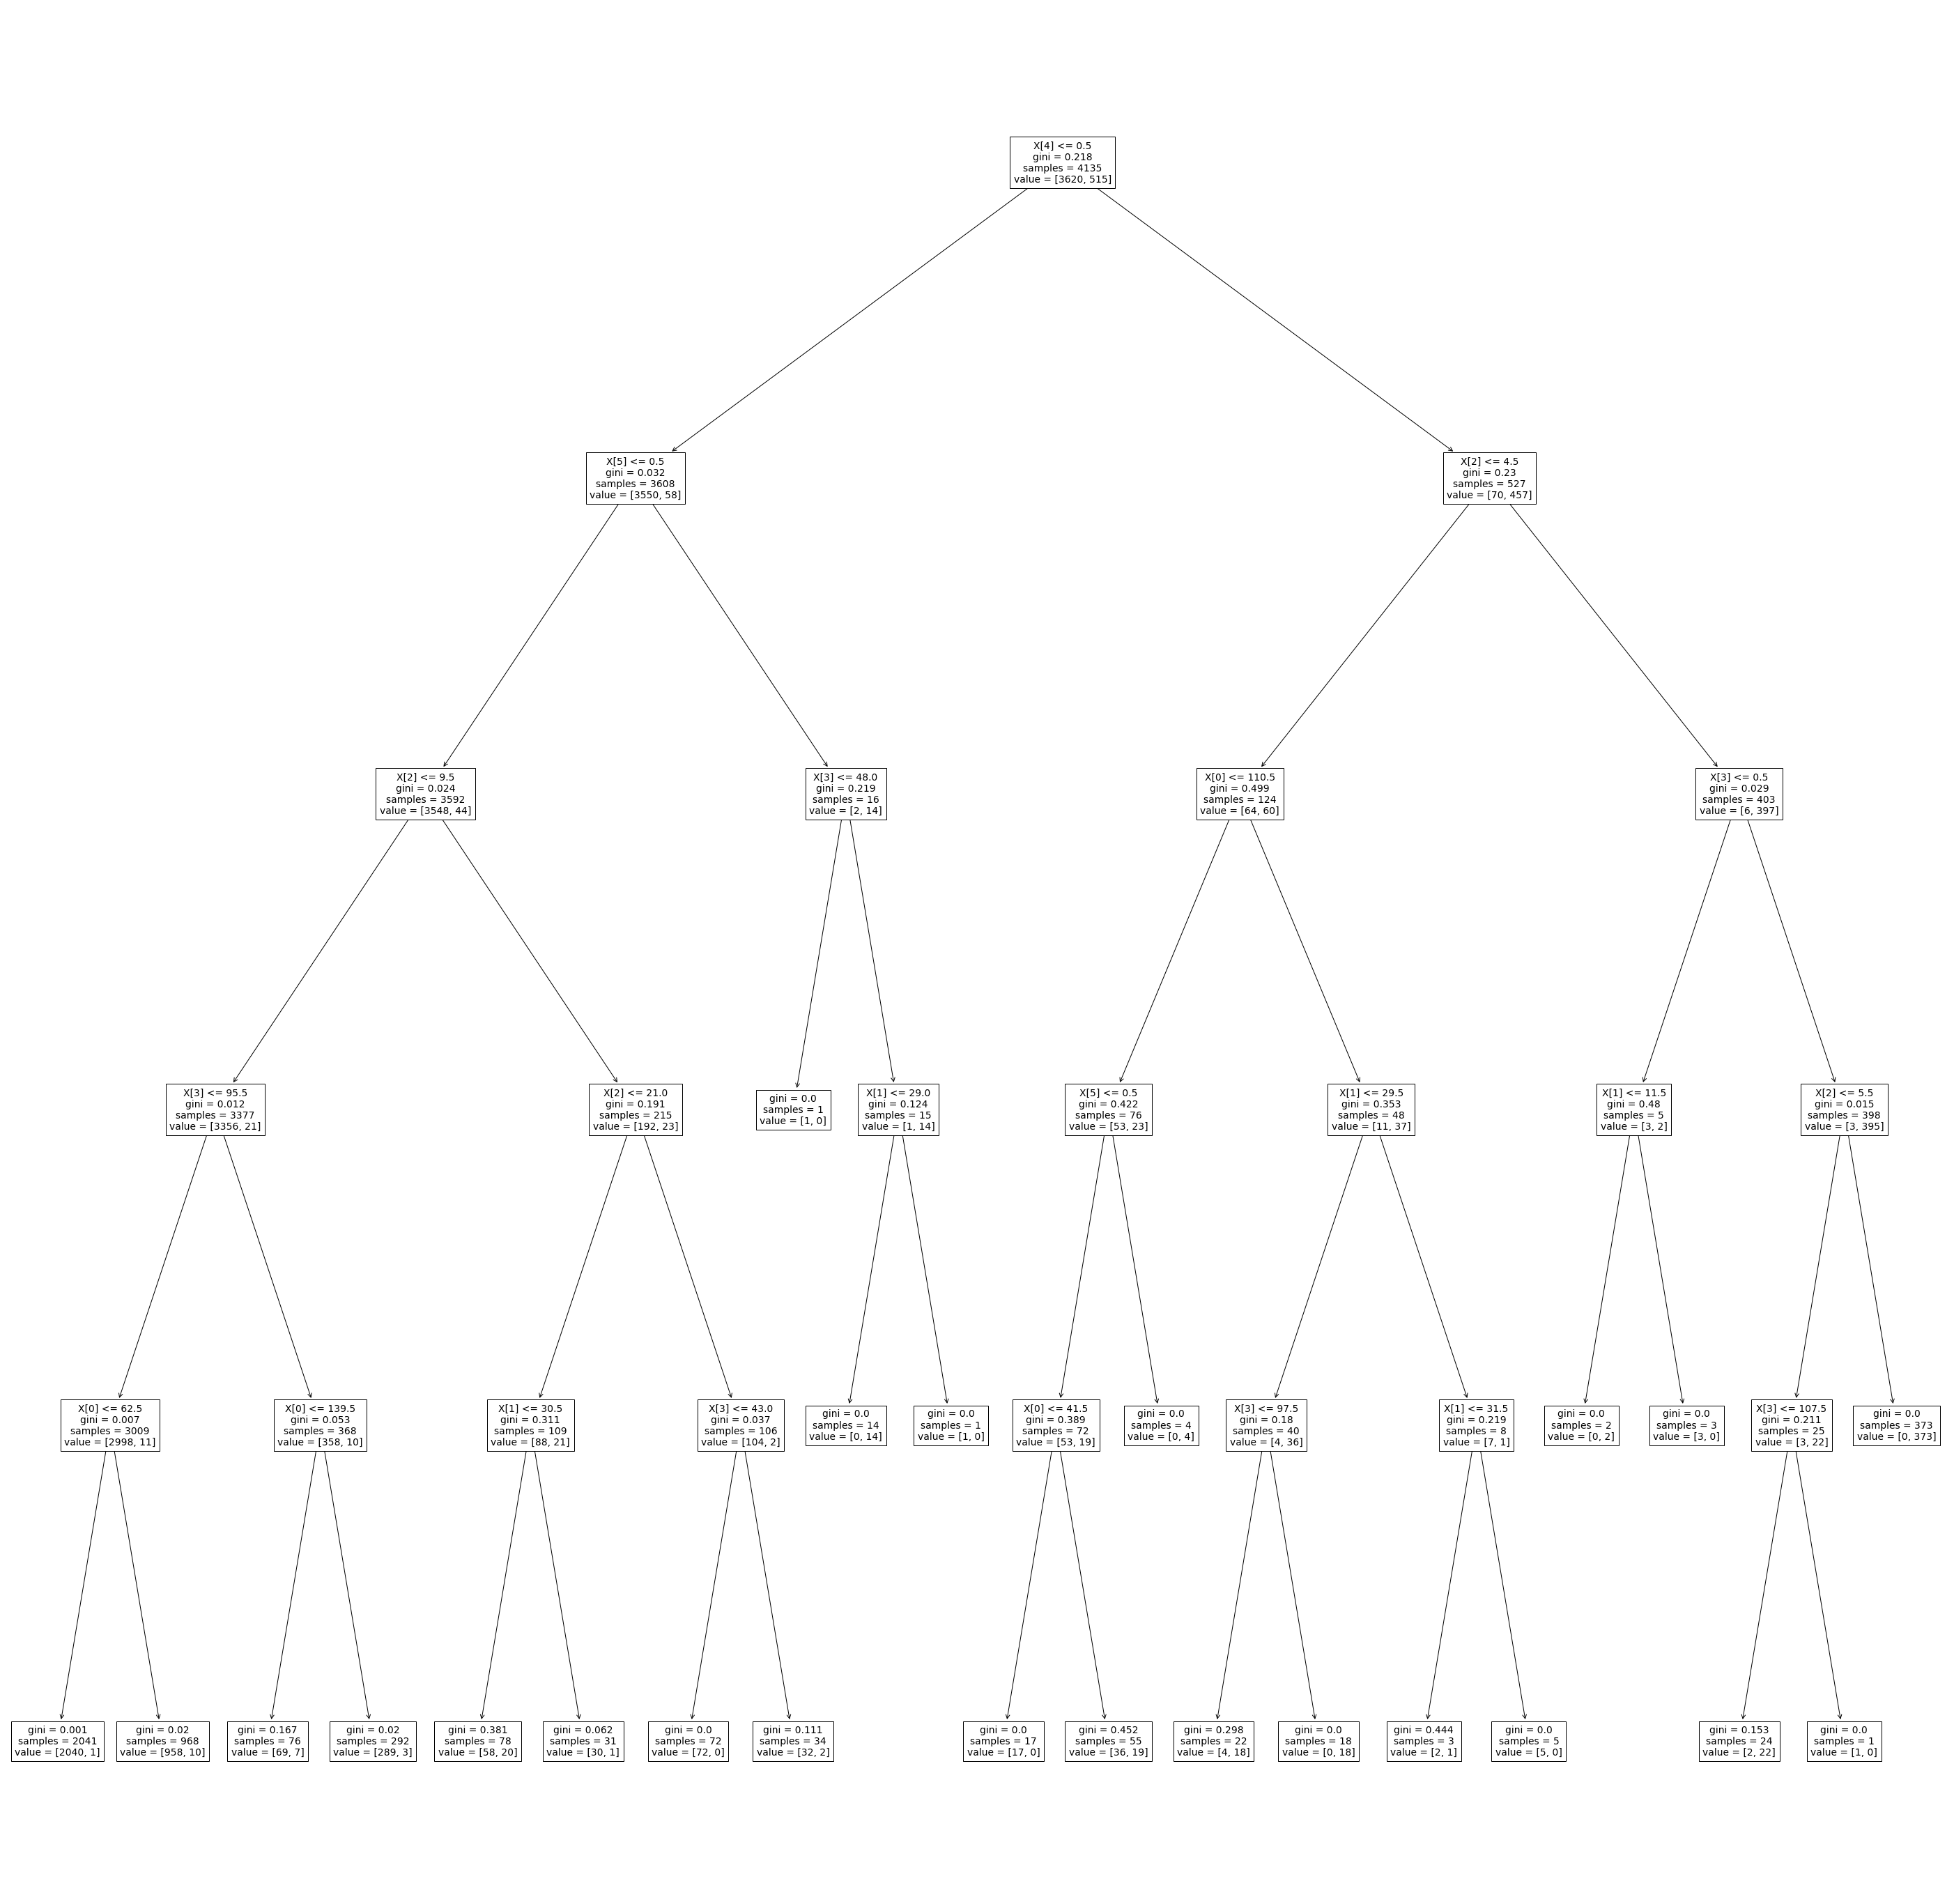

In [64]:
from sklearn import tree
# Step 1: Import the model you want to use
# This was already imported earlier in the notebook so commenting out
# Step 2: Make an instance of the Model
clf = tree.DecisionTreeClassifier(max_depth=5)
# Step 3: Train the model on the data
clf.fit(X_train, y_train)
# Step 4: Predict labels of unseen (test) data
# Not doing this step in the tutorial
# clf.predict(X_test)

plt.figure( figsize=(50,50))
tree.plot_tree(clf);

In [65]:
X_train.columns

Index(['length', 'words_count', 'uppercases_count', 'lowercases_count',
       'number_sequence', 'url_or_mail'],
      dtype='object')

In [66]:
#Export de l'arbre
"""
from sklearn.tree import export_graphviz

export_graphviz(
    pipe_model,
    out_file=None,
    feature_names=df.columns[1:],
    class_names='target',
    rounded=True,
    filled=True
)
"""

"\nfrom sklearn.tree import export_graphviz\n\nexport_graphviz(\n    pipe_model,\n    out_file=None,\n    feature_names=df.columns[1:],\n    class_names='target',\n    rounded=True,\n    filled=True\n)\n"

In [ ]:
Regression logistique
SVM
Arbre de decision
Xgboost
naives bayes
Reseau de neuronnes

In [152]:
class ModelEvaluation():
    
    # constructeur
    def __init__(self,preparation,model):
        self.model = model
        self.preparation = preparation
        self.pipe_m = None
        self.y_pred = None
        self.score = 0
        self.createPipeline()
        self.fitModel()
        self.predict()
        self.showScore()
        
    def createPipeline(self):
        self.pipe_m = Pipeline(steps=[
            ('preparation', preparation),
            ('model',self.model)
        ])
        self.pipe_m
        
    def fitModel(self):
        self.pipe_m.fit(X_train, y_train)
    
    def predict(self):
        self.y_pred = self.pipe_m.predict(X_test)
        
    def showScore(self):
        self.score = accuracy_score(y_test, self.y_pred)
        print(self.model,"score :", round(self.score, 5))

In [161]:
from sklearn.neighbors import KNeighborsClassifier

ModelEvaluation(preparation,DecisionTreeClassifier(max_depth=5))
ModelEvaluation(preparation,RandomForestClassifier(n_estimators=100))
ModelEvaluation(preparation,KNeighborsClassifier(n_neighbors=3))

DecisionTreeClassifier(max_depth=5) score : 0.94584
RandomForestClassifier() score : 0.94584
KNeighborsClassifier(n_neighbors=3) score : 0.94294
